In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import LabelEncoder


## 1. Import VNINDEX data

In [2]:
data_origin = pd.read_csv("\\...\\VNINDEX test.csv")
data_origin

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares)
0,VNINDEX,1/5/2004,169.16,169.16,167.69,167.69,3.78,"200,210"
1,VNINDEX,1/6/2004,170.26,170.78,170.26,170.78,3.83,"206,380"
2,VNINDEX,1/7/2004,171.17,171.17,170.84,170.84,2.03,"107,740"
3,VNINDEX,1/8/2004,171.60,171.79,171.6,171.79,3.82,"211,360"
4,VNINDEX,1/9/2004,173.27,173.27,171.44,171.44,2.09,"121,590"
...,...,...,...,...,...,...,...,...
4960,VNINDEX,12/7/2023,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475"
4961,VNINDEX,12/8/2023,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287"
4962,VNINDEX,12/11/2023,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929"
4963,VNINDEX,12/12/2023,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077"


This code is to select the time range to apply Directional Change (DC) indicator. In this case, I apply to the whole available timeframe. You can change a different timeframe.

In [3]:
# Convert 'TradingDate' to datetime format
data_origin['TradingDate'] = pd.to_datetime(data_origin['TradingDate'])

# Filter rows based on the date range
start_date = '2004-01-05'
end_date = '2023-12-13'
df = data_origin[(data_origin['TradingDate'] >= start_date) & (data_origin['TradingDate'] <= end_date)]

# Display the filtered DataFrame
df


,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares)
0,VNINDEX,2004-01-05,169.16,169.16,167.69,167.69,3.78,"200,210"
1,VNINDEX,2004-01-06,170.26,170.78,170.26,170.78,3.83,"206,380"
2,VNINDEX,2004-01-07,171.17,171.17,170.84,170.84,2.03,"107,740"
3,VNINDEX,2004-01-08,171.60,171.79,171.6,171.79,3.82,"211,360"
4,VNINDEX,2004-01-09,173.27,173.27,171.44,171.44,2.09,"121,590"
...,...,...,...,...,...,...,...,...
4960,VNINDEX,2023-12-07,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475"
4961,VNINDEX,2023-12-08,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287"
4962,VNINDEX,2023-12-11,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929"
4963,VNINDEX,2023-12-12,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077"


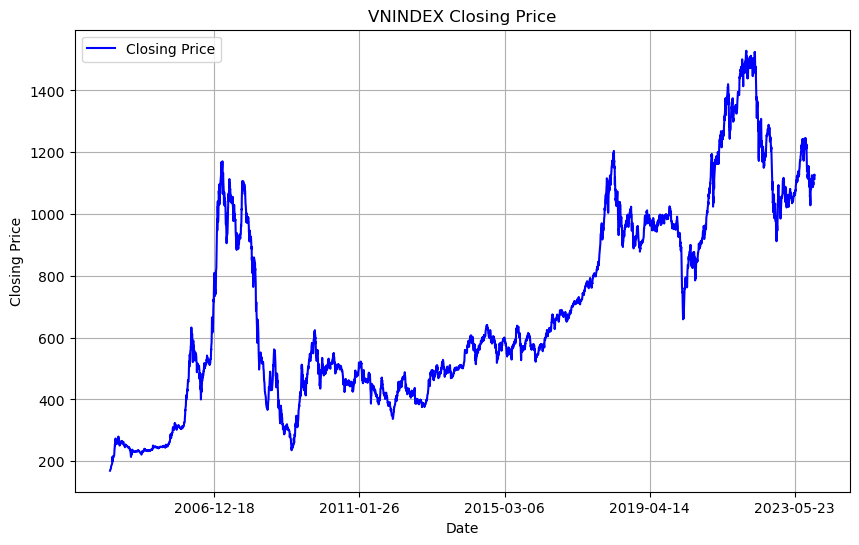

In [4]:
# Plotting the close price of the data
plt.figure(figsize=(10, 6))
plt.plot(df['TradingDate'], df['Close'], label='Closing Price', color='blue')
plt.title('VNINDEX Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=8))

plt.grid(True)
plt.show()


## 2. Calculate data

Calulate time series indicator: log return

In [5]:
df['LogReturn'] = df['Close'].pct_change().apply(lambda x: np.log(1 + x))

Calculate DC Return

In [6]:
threshold = 0.2
TMV_list = []
T_list = []
colors = []
events = []
trend= []
ext_point_list = []
curr_event_max_list = [] 
curr_event_min_list = []

ext_point_n = df['Close'].iloc[0]
curr_event_max = df['Close'].iloc[0]
curr_event_min = df['Close'].iloc[0]
time_point_max = 0
time_point_min = 0
trend_status = 'up'
T = 0

for i in range(len(df['Close'])):
    TMV = (abs(df['Close'].iloc[i] - ext_point_n)) / (ext_point_n * threshold)
    TMV_list.append(TMV)
    T_list.append(T)
    T += 1
    
    if trend_status == 'up':
        colors.append('lime')
        events.append('Upward Overshoot')
        trend.append(trend_status)

        if df['Close'].iloc[i] < ((1 - threshold) * curr_event_max):
            trend_status = 'down'
            curr_event_min = df['Close'].iloc[i]
            
            ext_point_n = curr_event_max
            T = i - time_point_max
            num_points_change = i - time_point_max
            
            for j in range(1, num_points_change + 1):
                colors[-j] = 'red'
                events[-j] = 'Downward DCC'
                trend[-j] = 'down'
                T_list[-j] = T+1-j
      
            
        else:
            if df['Close'].iloc[i] > curr_event_max:
                curr_event_max = df['Close'].iloc[i]
                time_point_max = i
          
    
    else:
        colors.append('lightcoral')
        events.append('Downward Overshoot')
        trend.append('down')

        if df['Close'].iloc[i] > ((1 + threshold) * curr_event_min):
            trend_status = 'up'
            curr_event_max = df['Close'].iloc[i]
            
            ext_point_n = curr_event_min
            T = i - time_point_min
            num_points_change = i - time_point_min
            for j in range(1, num_points_change + 1):
                colors[-j] = 'green'
                events[-j] = 'Upward DCC'
                trend[-j] = 'up'
                T_list[-j] = T+1-j
        else:
            if df['Close'].iloc[i] < curr_event_min:
                curr_event_min = df['Close'].iloc[i]
                time_point_min = i
                
            
                
    ext_point_list.append(ext_point_n)
    curr_event_max_list.append(curr_event_max) 
    curr_event_min_list.append(curr_event_min)
                
colors = np.array(colors)




Text(0, 0.5, 'Normalized TMV')

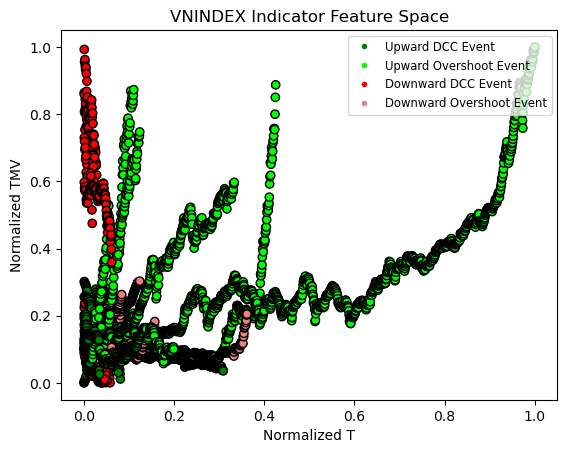

In [7]:
# Plot the indicator space
TMV_array = np.array(TMV_list)
T_array = np.array(T_list)
norm_TMV = (TMV_array - np.min(TMV_array)) / (np.max(TMV_array) - np.min(TMV_array))
norm_T = (T_array - np.min(T_array)) / (np.max(T_array) - np.min(T_array))

fig, ax = plt.subplots()
ax.scatter(norm_T, norm_TMV, c=colors, edgecolors='k')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5,
                              label='Upward DCC Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=5,
                              label='Upward Overshoot Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5,
                              label='Downward DCC Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=5,
                              label='Downward Overshoot Event')]
ax.legend(handles=legend_elements, loc='upper right', fontsize='small')
#ax.set_xlim(np.min(norm_T) - 0.1, np.max(norm_T) + 0.1)
#ax.set_ylim(np.min(norm_TMV) - 0.1, np.max(norm_TMV) + 0.1)
ax.set_title('VNINDEX Indicator Feature Space')
ax.set_xlabel('Normalized T')
ax.set_ylabel('Normalized TMV')


Collect all data into a dataframe, including DC indicator: LogReturnDC  and time series indicator:LogReturn

In [8]:
event_df = pd.DataFrame({
    'TradingDate': df['TradingDate'],
    'colors': colors,
    'events': events,
    'TMV': TMV_array,
    'Time':T_array,
    'extreme point':ext_point_list,
    'current max':curr_event_max_list,
    'current min':curr_event_min_list,
    'trend':trend
})


df_merged = pd.merge(df, event_df, on='TradingDate')

#Calculate TMV
df_merged['LogReturnDC'] = abs(df_merged['TMV'])*threshold/df_merged['Time']

# Display the resulting DataFrame
df_merged

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares),LogReturn,colors,events,TMV,Time,extreme point,current max,current min,trend,LogReturnDC
0,VNINDEX,2004-01-05,169.16,169.16,167.69,167.69,3.78,"200,210",NaN,lime,Upward Overshoot,0.000000,0,169.16,169.16,169.16,up,NaN
1,VNINDEX,2004-01-06,170.26,170.78,170.26,170.78,3.83,"206,380",0.006482,green,Upward DCC,0.032514,1,169.16,170.26,169.16,up,0.006503
2,VNINDEX,2004-01-07,171.17,171.17,170.84,170.84,2.03,"107,740",0.005331,green,Upward DCC,0.059411,2,169.16,171.17,169.16,up,0.005941
3,VNINDEX,2004-01-08,171.60,171.79,171.6,171.79,3.82,"211,360",0.002509,green,Upward DCC,0.072121,3,169.16,171.60,169.16,up,0.004808
4,VNINDEX,2004-01-09,173.27,173.27,171.44,171.44,2.09,"121,590",0.009685,green,Upward DCC,0.121483,4,169.16,173.27,169.16,up,0.006074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,VNINDEX,2023-12-07,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475",-0.004395,lime,Upward Overshoot,1.149194,265,911.90,1245.50,911.90,up,0.000867
4961,VNINDEX,2023-12-08,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287",0.002627,lime,Upward Overshoot,1.165369,266,911.90,1245.50,911.90,up,0.000876
4962,VNINDEX,2023-12-11,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929",0.000942,lime,Upward Overshoot,1.171181,267,911.90,1245.50,911.90,up,0.000877
4963,VNINDEX,2023-12-12,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077",0.001891,lime,Upward Overshoot,1.182860,268,911.90,1245.50,911.90,up,0.000883


Plot the close price with DC Event Classification

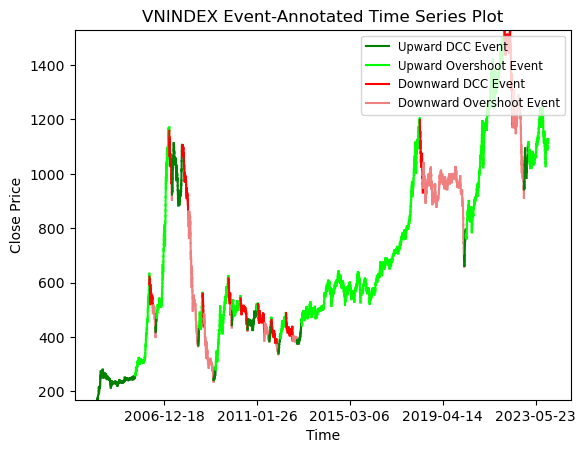

In [9]:
green_patch = plt.Line2D([0], [0], color='green', label='Upward DCC Event')
lime_patch = plt.Line2D([0], [0], color='lime', label='Upward Overshoot Event')
red_patch = plt.Line2D([0], [0], color='red', label='Downward DCC Event')
lightcoral_patch = plt.Line2D([0], [0], color='lightcoral', label='Downward Overshoot Event')

fig1, ax1 = plt.subplots()
ax1.ticklabel_format(style='plain', axis='y', useOffset=False)
for i, color in enumerate(colors):
    ax1.plot(df['TradingDate'][i: i + 2], df['Close'][i: i + 2], color=color)
   
#ax1.set_xlim(0, len(df['close']) - 1)
ax1.set_ylim(df['Close'].min() * 0.9999, df['Close'].max() * 1.0001)
ax1.set_title('VNINDEX Event-Annotated Time Series Plot')
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price')
ax1.legend(handles=[green_patch, lime_patch, red_patch, lightcoral_patch], loc='upper right', fontsize='small')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
plt.show()

## 3. Fit Hidden Marlov Model and plot

Fit DC indicator: LogReturnDC and time series indicator:LogReturn in to Hidden Markov Model, assumming they follow Gaussian distribution

In [10]:
df= df_merged

# Drop NaN values and reset the index
df = df.dropna().reset_index(drop=True)

X = df[['LogReturnDC']].values

# Fit Gaussian HMM model
model = GaussianHMM(n_components=2, covariance_type='full', algorithm="viterbi")
model.fit(X)

# Predict the hidden states
hidden_states = model.predict(X)

# Add the hidden states as a new column in the DataFrame
df['hidden_states'] = hidden_states

# Decode the hidden states back to categorical values
df['hidden_states'] = np.where(df['hidden_states'] == 0, 'State0', 'State1')

# Display the resulting DataFrame with hidden states
print(df)

       Ticker TradingDate    Close   Highest    Lowest      Open  \
0     VNINDEX  2004-01-06   170.26    170.78    170.26    170.78   
1     VNINDEX  2004-01-07   171.17    171.17    170.84    170.84   
2     VNINDEX  2004-01-08   171.60    171.79     171.6    171.79   
3     VNINDEX  2004-01-09   173.27    173.27    171.44    171.44   
4     VNINDEX  2004-01-12   174.13    174.13    173.46    173.46   
...       ...         ...      ...       ...       ...       ...   
4956  VNINDEX  2023-12-07  1121.49  1,129.83  1,109.51  1,128.67   
4957  VNINDEX  2023-12-08  1124.44  1,127.46  1,119.43  1,122.09   
4958  VNINDEX  2023-12-11  1125.50  1,129.15  1,120.32  1,127.92   
4959  VNINDEX  2023-12-12  1127.63  1,129.77  1,123.35  1,127.55   
4960  VNINDEX  2023-12-13  1114.20  1,131.21  1,112.08  1,129.94   

     Total Trading Value (billion VND) Total Trading Volume (shares)  \
0                                 3.83                       206,380   
1                                 2.03 

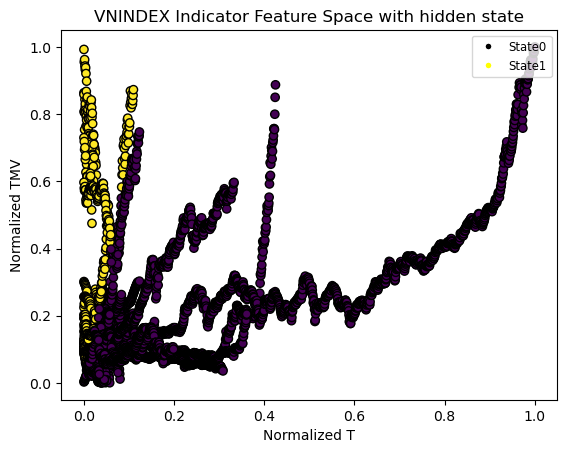

In [11]:
# Plot indicator space with hidden state
TMV_list = df['TMV'].tolist()
T_list = df['Time'].tolist()

# Use LabelEncoder to encode the 'hidden_states' column
label_encoder = LabelEncoder()
encoded_states = label_encoder.fit_transform(df['hidden_states'])

# Normalize the data
TMV_array = np.array(TMV_list)
T_array = np.array(T_list)
norm_TMV = (TMV_array - np.min(TMV_array)) / (np.max(TMV_array) - np.min(TMV_array))
norm_T = (T_array - np.min(T_array)) / (np.max(T_array) - np.min(T_array))

# scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(norm_T, norm_TMV, c=encoded_states, cmap='viridis', edgecolors='k')

# legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State0'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=5, label='State1'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize='small')

# Set axis labels and title
ax.set_title('VNINDEX Indicator Feature Space with hidden state')
ax.set_xlabel('Normalized T')
ax.set_ylabel('Normalized TMV')

# Display the plot
plt.show()


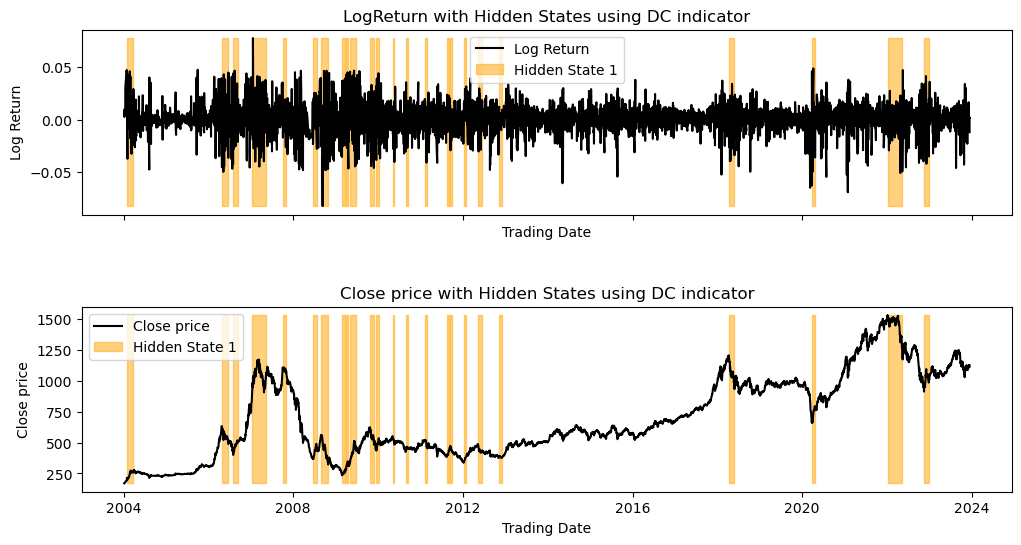

In [12]:
# Plotting graphs that use DC indicator
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12, 6))

# Plot log returns
ax1.plot(df['TradingDate'], df['LogReturn'], color='black', label='Log Return')
ax1.fill_between(df['TradingDate'], min(df['LogReturn']), max(df['LogReturn']), where=(df['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')

# Plot close price
ax2.plot(df['TradingDate'], df['Close'], color='black', label='Close price')
ax2.fill_between(df['TradingDate'], min(df['Close']), max(df['Close']), where=(df['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')


ax1.set_title('LogReturn with Hidden States using DC indicator')
ax1.set_xlabel('Trading Date')
ax1.set_ylabel('Log Return')
ax1.legend()

ax2.set_title('Close price with Hidden States using DC indicator')
ax2.set_xlabel('Trading Date')
ax2.set_ylabel('Close price')
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()


Fit time series indicator:LogReturn in to Hidden Markov Model, assumming it follows Gaussian distribution

In [13]:
df = df_merged

# Drop NaN values and reset the index
df = df.dropna().reset_index(drop=True)

Y = df[['LogReturn']].values

# Fit Gaussian HMM model
model = GaussianHMM(n_components=2, covariance_type='full', algorithm="viterbi")
model.fit(Y)

# Predict the hidden states
hidden_states = model.predict(Y)

# Add the hidden states as a new column in the DataFrame
df['hidden_states'] = hidden_states

# Decode the hidden states back to categorical values
df['hidden_states'] = np.where(df['hidden_states'] == 0, 'State0', 'State1')

# Display the resulting DataFrame with hidden states
print(df)

       Ticker TradingDate    Close   Highest    Lowest      Open  \
0     VNINDEX  2004-01-06   170.26    170.78    170.26    170.78   
1     VNINDEX  2004-01-07   171.17    171.17    170.84    170.84   
2     VNINDEX  2004-01-08   171.60    171.79     171.6    171.79   
3     VNINDEX  2004-01-09   173.27    173.27    171.44    171.44   
4     VNINDEX  2004-01-12   174.13    174.13    173.46    173.46   
...       ...         ...      ...       ...       ...       ...   
4956  VNINDEX  2023-12-07  1121.49  1,129.83  1,109.51  1,128.67   
4957  VNINDEX  2023-12-08  1124.44  1,127.46  1,119.43  1,122.09   
4958  VNINDEX  2023-12-11  1125.50  1,129.15  1,120.32  1,127.92   
4959  VNINDEX  2023-12-12  1127.63  1,129.77  1,123.35  1,127.55   
4960  VNINDEX  2023-12-13  1114.20  1,131.21  1,112.08  1,129.94   

     Total Trading Value (billion VND) Total Trading Volume (shares)  \
0                                 3.83                       206,380   
1                                 2.03 

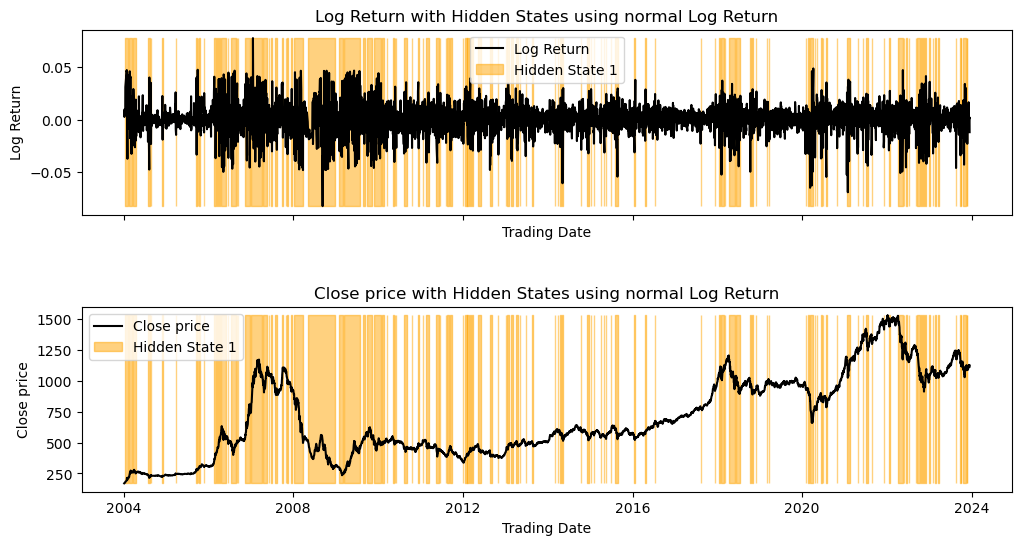

In [14]:
# Plotting graphs that use tinme series indicator

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12, 6))

# Plot log returns
ax1.plot(df['TradingDate'], df['LogReturn'], color='black', label='Log Return')
ax1.fill_between(df['TradingDate'], min(df['LogReturn']), max(df['LogReturn']), where=(df['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')

# Plot close price
ax2.plot(df['TradingDate'], df['Close'], color='black', label='Close price')
ax2.fill_between(df['TradingDate'], min(df['Close']), max(df['Close']), where=(df['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')


ax1.set_title('Log Return with Hidden States using normal Log Return')
ax1.set_xlabel('Trading Date')
ax1.set_ylabel('Log Return')
ax1.legend()

ax2.set_title('Close price with Hidden States using normal Log Return')
ax2.set_xlabel('Trading Date')
ax2.set_ylabel('Close price')
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()
